# Quora Question Pair Similarity 

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Data Preprocessing <br>
4. Exploratory Data Analysis
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Quora Question Pairs. Link:https://www.kaggle.com/c/quora-question-pairs 
2. **Data:** Genuine questions from Quora.
3. **Task:** For a given pair of questions we need to predict if they are duplicate or not. 
4. **Relevant Info:** Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.<br>
<br>
5. **Data includes:** 
    * **id** - the id of a training set question pair
    * **qid1, qid2** - unique ids of each question (only available in train.csv)
    * **question1, question2** - the full text of each question
    * **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.<br>
<br>
6. **Data Overview:** 
    * Data will be in a file Train.csv
    * Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
    * Size of Train.csv - 60MB
    * Number of rows in Train.csv = 404,290 

## 2. Real-world/Business objective and constraints

**Objective:** It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. 
<br>
<br>**Constraints:**
<br>

* The cost of a mis-classification can be very high.
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns.
* Interpretability is partially important.

## 3. Data and Libraries Loading

In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
import os
from os import path
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('train.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  404290
Number of features :  6
Features :  ['id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate']


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## 4. Exploratory Data Analysis (EDA)

### [A] Distribution of Classes

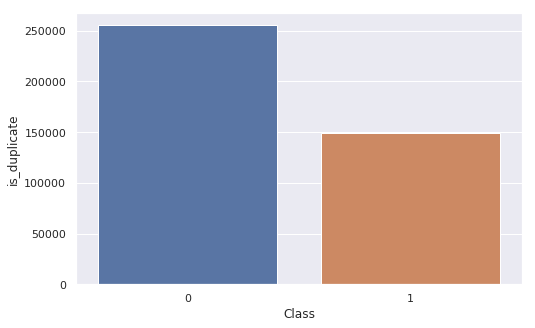

In [4]:
sns.set()
plt.figure(figsize = (8, 5))
plt.xlabel('Class')
sns.barplot(x = np.unique(data.is_duplicate), y = data.is_duplicate.value_counts(), alpha = 1)

#### Observation:
* There is more non-similar question pairs than similar pairs.

In [5]:
print('Similar question pair(is_duplicate = 1) rate is :', data.is_duplicate.value_counts()[1] / len(data))
print('Non-similar question pair (is_duplicate = 0) rate is :', data.is_duplicate.value_counts()[0] / len(data))

Similar question pair(is_duplicate = 1) rate is : 0.369197853026293
Non-similar question pair (is_duplicate = 0) rate is : 0.630802146973707


#### Observation:
* Only 37% of the question pairs are similar, whereas 63% are non similar.

### [B] Distribution of Questions

In [6]:
all_qs = pd.Series(data.qid1.tolist() + data.qid2.tolist())
unique_qs = len(np.unique(all_qs))
qs_more_than_one = np.sum(all_qs.value_counts() > 1)
max_repeated_q = all_qs.value_counts().max()
print('Number of Unique Questions are :', unique_qs)
print('Number of Questions that are asked more than once :', qs_more_than_one)
print('Maximum number of times a single question is repeated :', max_repeated_q)

Number of Unique Questions are : 537933
Number of Questions that are asked more than once : 111780
Maximum number of times a single question is repeated : 157


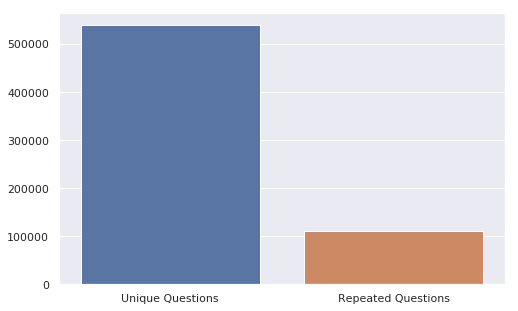

In [7]:
x = ['Unique Questions', 'Repeated Questions']
y = [unique_qs, qs_more_than_one]
plt.figure(figsize = (8, 5))
sns.barplot(x, y, alpha = 1)

#### Observation:
* The dataset contains more unique question than repeated ones.

In [8]:
pair_duplicate = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Number of duplicate entries :', pair_duplicate.shape[0] - data.shape[0])

Number of duplicate entries : 0


Max appearence of a question is : 157


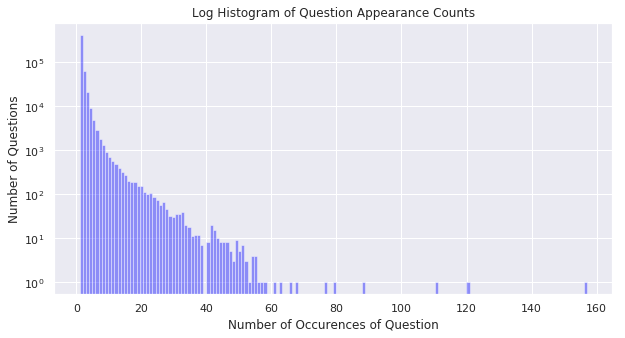

In [9]:
plt.figure(figsize = (10, 5))
sns.distplot(all_qs.value_counts(), kde = False, color = 'blue', bins = 160)
plt.yscale('log')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
plt.title('Log Histogram of Question Appearance Counts')
print('Max appearence of a question is :', max_repeated_q)

#### Observation:
* Most questions are unique in this dataset.

### [C] Null Entry Check

In [10]:
nan_rows = data[data.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [11]:
data = data.dropna(axis = 0)

In [12]:
data.shape

(404287, 6)

#### Observation:
* The dataset contains 3 entries with NaN value in column question1 and question2. 
* And these 3 rows are removed as there is no scarcity of data.

## 5. Basic Feature Extraction

*    **freq_qid1**       = Frequency of qid1's
*    **freq_qid2**       = Frequency of qid2's
*    **q1len**           = Length of q1
*    **q2len**           = Length of q2
*    **q1_n_words**      = Number of words in Question 1
*    **q2_n_words**      = Number of words in Question 2
*    **word_common**     = (Number of common unique words in Question 1 and Question 2)
*    **word_total**      = (Total num of words in Question 1 + Total num of words in Question 2)
*    **word_share**      = (word_common)/(word_Total)
*    **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
*    **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [28]:
extracted_data = data

In [43]:
extracted_data['freq_qid1'] = extracted_data.groupby('qid1')['qid1'].transform('count')
extracted_data['freq_qid2'] = extracted_data.groupby('qid2')['qid2'].transform('count')
extracted_data['q1len'] = extracted_data['question1'].str.len()
extracted_data['q2len'] = extracted_data['question2'].str.len()
extracted_data['q1_n_words'] = extracted_data['question1'].apply(lambda row: len(row.split(' ')))
extracted_data['q2_n_words'] = extracted_data['question2'].apply(lambda row: len(row.split(' ')))

def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower(), row['question2'].split(' ')))
    return 1.0 * len(w1 & w2)

def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower(), row['question2'].split(' ')))
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower(), row['question2'].split(' ')))
    return 1.0 * (len(w1 & w2) / (len(w1) + len(w2)))

extracted_data['word_common'] = extracted_data.apply(normalized_word_common, axis = 1)
extracted_data['word_total'] = extracted_data.apply(normalized_word_total, axis = 1)
extracted_data['word_share'] = extracted_data.apply(normalized_word_share, axis = 1)
extracted_data['freq_q1+q2'] = extracted_data['freq_qid1'] + extracted_data['freq_qid2']
extracted_data['freq_q1-q2'] = abs(extracted_data['freq_qid2'] - extracted_data['freq_qid2'])

In [44]:
extracted_data.to_csv('feature_without_preprocessing.csv', index = False)

In [45]:
extracted_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,0


In [54]:
print('Maximum question length in question1 is :', min(extracted_data['q1_n_words']))
print('Minimum question length in question2 is :', min(extracted_data['q2_n_words']))
print('Number of questions with minimum length [question 1]:', extracted_data[extracted_data['q1_n_words'] == 1].shape[0])
print('Number of questions with minimum length [question 2]:', extracted_data[extracted_data['q2_n_words'] == 1].shape[0])

Maximum question length in question1 is : 1
Minimum question length in question2 is : 1
Number of questions with minimum length [question 1]: 66
Number of questions with minimum length [question 2]: 22


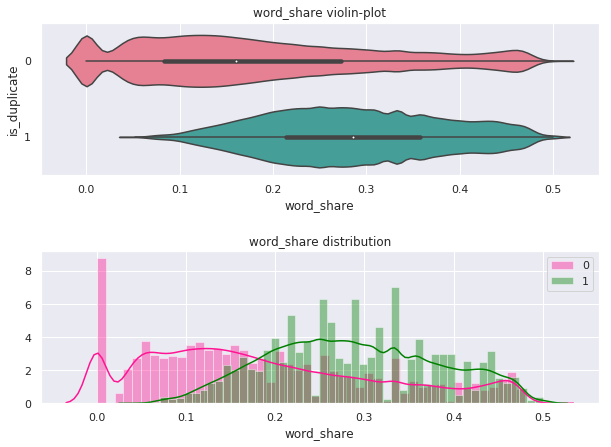

In [79]:
plt.figure(figsize = (10, 7))
plt.subplot(2,1,1)
ax = sns.violinplot(y = 'is_duplicate', x = 'word_share', data = extracted_data, palette = 'husl', orient = 'h')
ax.set_title('word_share violin-plot')

plt.subplot(2,1,2)
ax = sns.distplot(extracted_data[extracted_data['is_duplicate'] == 0]['word_share'], label = '0', color = 'deeppink')
ax = sns.distplot(extracted_data[extracted_data['is_duplicate'] == 1]['word_share'], label = '1', color = 'green')
ax.set_title('word_share distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Observation:
* The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.
* It seems from 0.0% to 0.05% word share are not similar which is more reasonable.
* But there are cases where word share is there even if they are not similar questions.

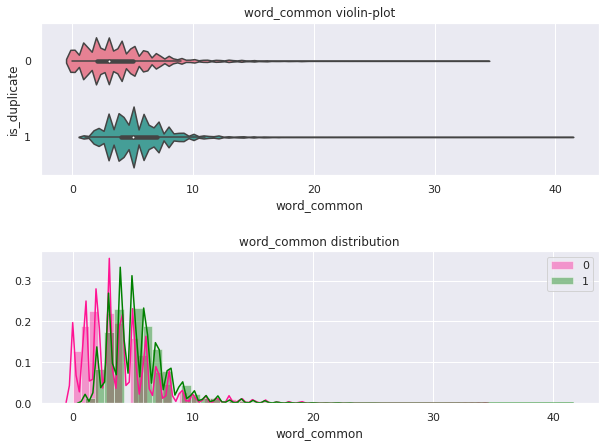

In [80]:
plt.figure(figsize = (10, 7))
plt.subplot(2,1,1)
ax = sns.violinplot(y = 'is_duplicate', x = 'word_common', data = extracted_data, palette = 'husl', orient = 'h')
ax.set_title('word_common violin-plot')

plt.subplot(2,1,2)
ax = sns.distplot(extracted_data[extracted_data['is_duplicate'] == 0]['word_common'], label = '0', color = 'deeppink')
ax = sns.distplot(extracted_data[extracted_data['is_duplicate'] == 1]['word_common'], label = '1', color = 'green')
ax.set_title('word_common distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Observation:
*  The distributions of the word_common feature in similar and non-similar questions are highly overlapping.

## 6. Text Preprocessing

* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [85]:
def preprocess(text_data):
    txt_data = str(text_data).lower()
    txt_data = txt_data.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    text_data = re.sub(r"([0-9]+)000000", r"\1m", text_data)
    text_data = re.sub(r"([0-9]+)000", r"\1k", text_data)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(text_data) == type(''):
        text_data = re.sub(pattern, ' ', text_data)
    
    
    if type(text_data) == type(''):
        text_data = porter.stem(text_data)
        example1 = BeautifulSoup(text_data)
        text_data = example1.get_text()
               
    
    return text_data

## 7. Advanced Feature Extraction (NLP and Fuzzy Features)

* cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2<br>
  cwc_min = common_word_count / (min(len(q1_words), len(q2_words))<br>
<br>
* cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2<br>
  cwc_max = common_word_count / (max(len(q1_words), len(q2_words))<br>
<br>
* csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2<br>
  csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))<br>
<br>
* csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>
  csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))<br>
<br>
* ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>
  ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))<br>
<br>
* ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>
  ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))<br>
<br>
* last_word_eq : Check if First word of both questions is equal or not<br>
  last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])<br>
<br>
* first_word_eq : Check if First word of both questions is equal or not<br>
  first_word_eq = int(q1_tokens[0] == q2_tokens[0])<br>
<br>
* abs_len_diff : Abs. length difference<br>
  abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))<br>
<br>
* mean_len : Average Token Length of both Questions<br>
  mean_len = (len(q1_tokens) + len(q2_tokens))/2<br>
<br>
* longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>
  longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))<br>
<br>
* fuzz_ratio<br> 
<br> 
* fuzz_partial_ratio<br> 
<br> 
* token_sort_ratio<br> 
<br> 
* token_set_ratio<br> 


In [86]:
def get_token_features(q1, q2):
    STOP_WORDS = stopwords.words("english")
    SAFE_DIV = 0.0001
    token_features = [0.0] * 10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string
from difflib import SequenceMatcher
def get_longest_substr_ratio(q1, q2):
    match = SequenceMatcher(None, q1, q2).find_longest_match(0, len(q1), 0, len(q2))
    lcs = q1[match.a: match.a + match.size]
    if len(lcs.split()) == 0:
        return 0
    else:
        return len(lcs.split()) / (min(len(q1), len(q2)) + 1)

def extract_features():
    # preprocessing each question
    extracted_data["question1"] = extracted_data["question1"].fillna("").apply(preprocess)
    extracted_data["question2"] = extracted_data["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = extracted_data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    extracted_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    extracted_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    extracted_data["csc_min"]       = list(map(lambda x: x[2], token_features))
    extracted_data["csc_max"]       = list(map(lambda x: x[3], token_features))
    extracted_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    extracted_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    extracted_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    extracted_data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    extracted_data["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    extracted_data["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    extracted_data["token_set_ratio"]       = extracted_data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    extracted_data["token_sort_ratio"]      = extracted_data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    extracted_data["fuzz_ratio"]            = extracted_data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    extracted_data["fuzz_partial_ratio"]    = extracted_data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    extracted_data["longest_substr_ratio"]  = extracted_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return extracted_data